In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from venn_abers import VennAbersCalibrator
from mapie.metrics.calibration import expected_calibration_error

In [7]:
def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return float(np.mean(np.abs(pt - pp))), pt, pp


(array([155., 136., 118.,  99.,  89.,  72.,  61.,  51.,  37.,  32.,  23.,
         16.,  17.,  10.,  14.,  12.,  11.,   9.,   9.,   6.,   2.,   5.,
          4.,   5.,   0.,   2.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.47367840e-07, 6.28601588e-04, 1.25655581e-03, 1.88451003e-03,
        2.51246425e-03, 3.14041847e-03, 3.76837269e-03, 4.39632691e-03,
        5.02428113e-03, 5.65223535e-03, 6.28018957e-03, 6.90814379e-03,
        7.53609801e-03, 8.16405223e-03, 8.79200645e-03, 9.41996067e-03,
        1.00479149e-02, 1.06758691e-02, 1.13038233e-02, 1.19317775e-02,
        1.25597318e-02, 1.31876860e-02, 1.38156402e-02, 1.44435944e-02,
        1.50715486e-02, 1.56995029e-02, 1.63274571e-02, 1.69554113e-02,
        1.75833655e-02, 1.82113197e-02, 1.88392740e-02, 1.94672282e-02,
        2.00951824e-02, 2.07231366e-02, 2.13510908e-02, 2.19790451e-02,
        2.

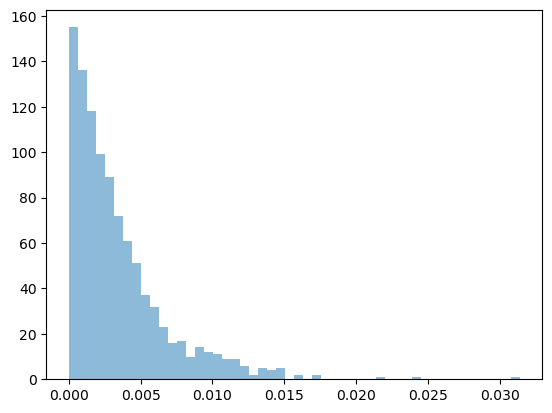

In [162]:
rng = np.random.default_rng(42)
plt.hist(rng.beta(1, 300, size=1000), bins=50, alpha=0.5, label='Beta(10,5)')

In [165]:
def run_simulation(counts, title="Simulation"):
    rng = np.random.default_rng(42)


    # Class 0: mixture of two Betas(2,5) and (1,8)
    probs_0 = 0.7 * rng.beta(2, 5, size=counts[0]) + 0.3 * rng.beta(1, 8, size=counts[0]) * rng.choice([-1, 1], size=counts[0])
    probs_0 = np.clip(probs_0, 0, 1)

    rng = np.random.default_rng(0)
    # Class 1: mixture of two Betas(10,5) and (1,8)
    probs_1 = 0.7 * rng.beta(10, 5, size=counts[1]) + 0.3 * rng.beta(1, 8, size=counts[1]) * rng.choice([-1, 1], size=counts[1])
    probs_1 = np.clip(probs_1, 0, 1)

    df_sim = pd.DataFrame({
        "y": np.concatenate([np.zeros(counts[0], int), np.ones(counts[1], int)]),
        "proba": np.concatenate([probs_0, probs_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(8,5))
    sns.histplot(df_sim[df_sim["y"]==0]["proba"], bins=30, color="blue", label="Class 0", stat="density", alpha=0.5)
    sns.histplot(df_sim[df_sim["y"]==1]["proba"], bins=30, color="red", label="Class 1", stat="density", alpha=0.5)

    sns.kdeplot(df_sim[df_sim["y"]==0]["proba"], color="blue", lw=2)
    sns.kdeplot(df_sim[df_sim["y"]==1]["proba"], color="red", lw=2)

    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.title(f"Simulated Probabilities by Class {title}")
    plt.legend()
    plt.show()

    # print(f"\n=== {title} ===")
    # print(df_sim.groupby("y")["proba"].describe())

    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["proba"]].values, df_sim["y"].values,
        test_size=0.3, stratify=df_sim["y"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()

    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)

    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)

    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]

    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }

    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": log_loss(y, p),
                "Brier": brier_score_loss(y, p),
                "ROC_AUC": roc_auc_score(y, p),
                "ECE": ece,
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)

    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")

    # --- Calibration curves: CAL set ---
    plt.figure(figsize=(6,6))
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Calibration curves: TEST set ---
    plt.figure(figsize=(6,6))
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()


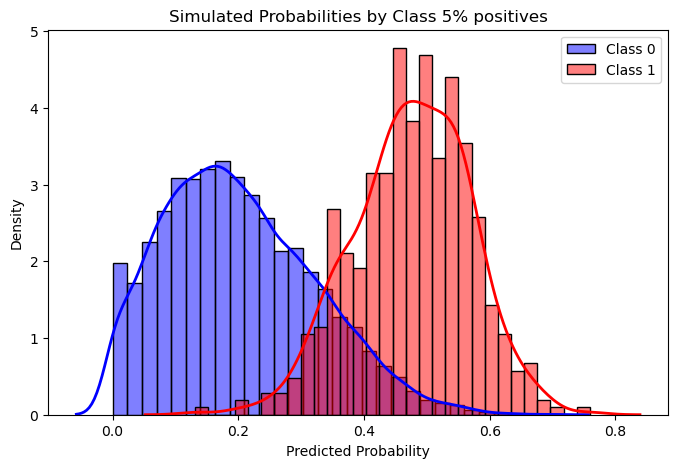


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2652,0.0669,0.9586,0.1670
Platt,0.1003,0.0300,0.9586,0.0023
Isotonic,0.0970,0.0292,0.9604,0.0000
Venn-Abers-IVAP,0.0983,0.0293,0.9600,0.0024



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2596,0.0652,0.9520,0.1606
Platt,0.1048,0.0301,0.9520,0.0077
Isotonic,0.1361,0.0304,0.9520,0.0121
Venn-Abers-IVAP,0.1040,0.0302,0.9527,0.0063


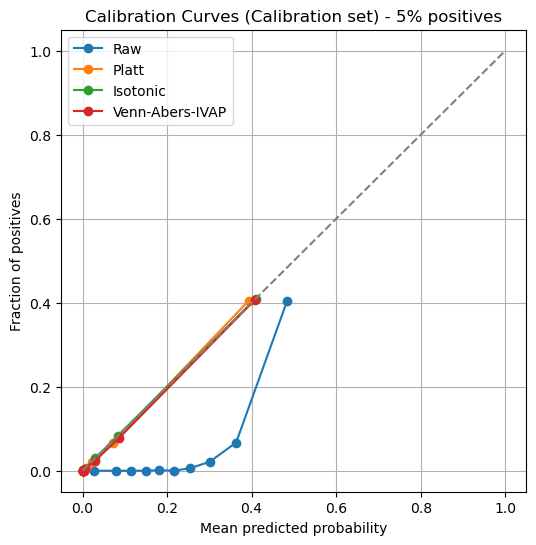

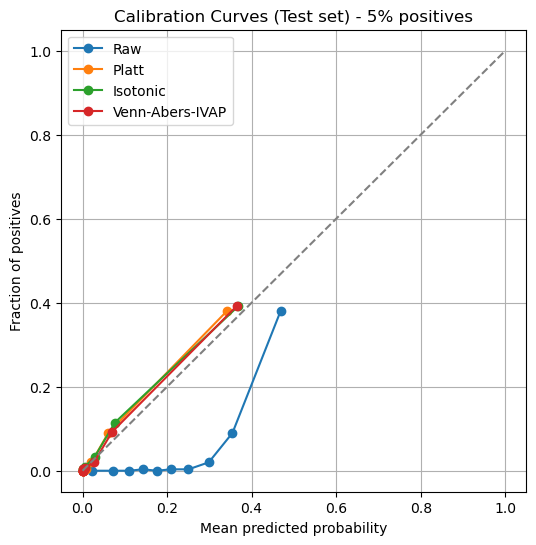

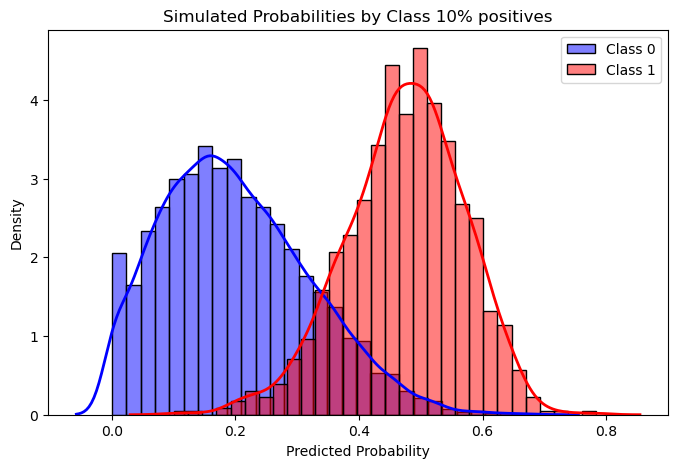


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2884,0.0772,0.9540,0.1600
Platt,0.1533,0.0461,0.9540,0.0028
Isotonic,0.1494,0.0453,0.9556,0.0000
Venn-Abers-IVAP,0.1505,0.0454,0.9553,0.0034



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2890,0.0773,0.9585,0.1643
Platt,0.1487,0.0447,0.9585,0.0065
Isotonic,0.1599,0.0447,0.9574,0.0050
Venn-Abers-IVAP,0.1485,0.0446,0.9578,0.0056


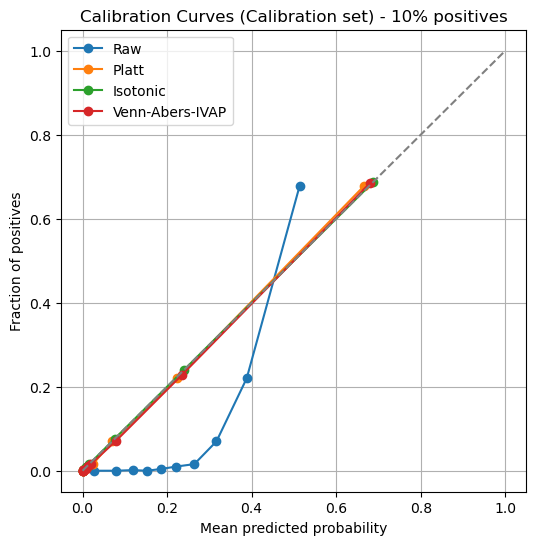

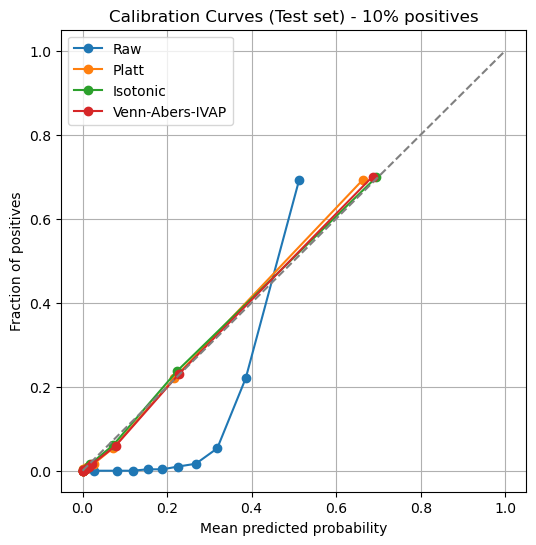

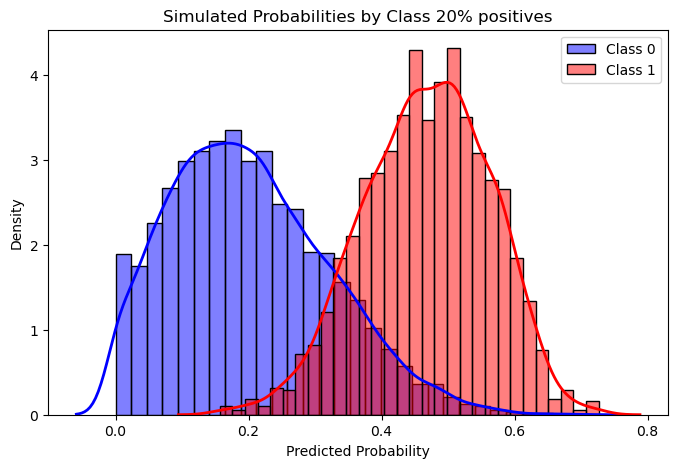


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3448,0.1017,0.9529,0.1576
Platt,0.2195,0.0687,0.9529,0.0056
Isotonic,0.2142,0.0674,0.9541,0.0000
Venn-Abers-IVAP,0.2154,0.0676,0.9539,0.0035



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3478,0.1029,0.9492,0.1608
Platt,0.2265,0.0705,0.9492,0.0116
Isotonic,0.2287,0.0712,0.9484,0.0124
Venn-Abers-IVAP,0.2281,0.0711,0.9489,0.0097


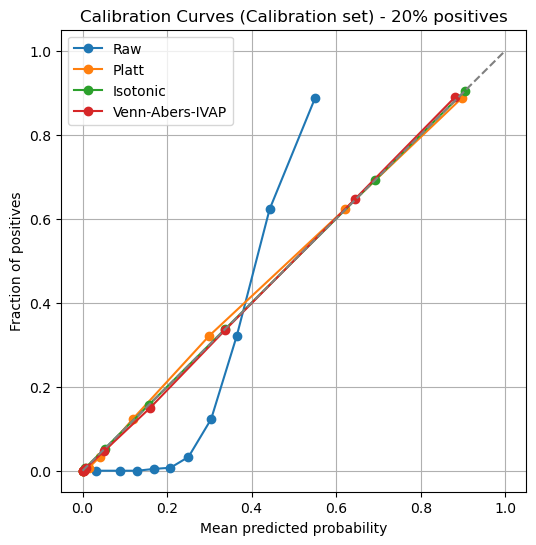

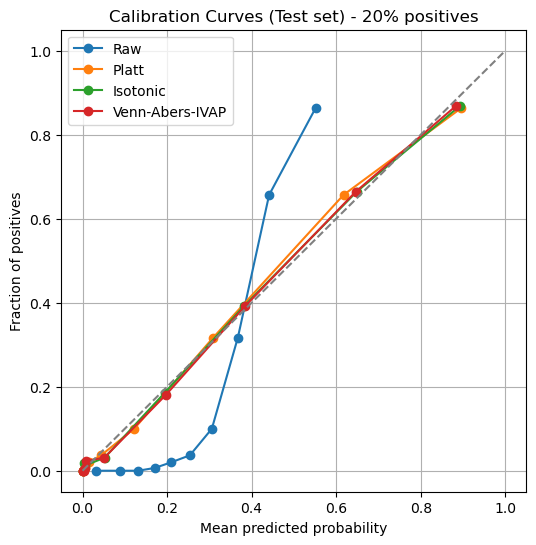

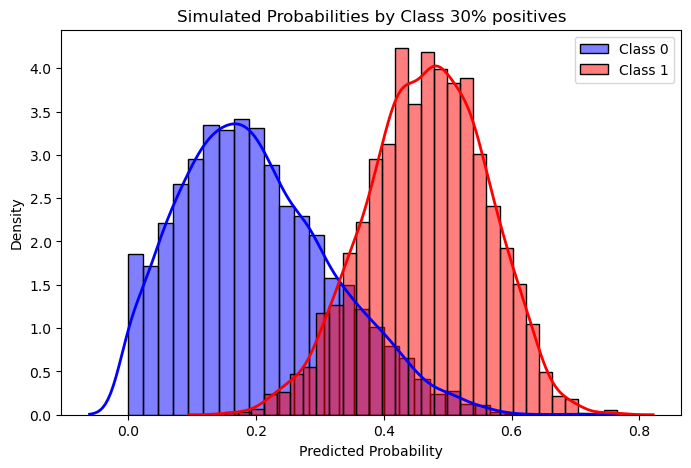


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4005,0.1260,0.9516,0.1804
Platt,0.2564,0.0807,0.9516,0.0091
Isotonic,0.2514,0.0795,0.9526,0.0000
Venn-Abers-IVAP,0.2527,0.0796,0.9525,0.0043



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3985,0.1251,0.9553,0.1824
Platt,0.2476,0.0778,0.9553,0.0152
Isotonic,0.2476,0.0783,0.9554,0.0225
Venn-Abers-IVAP,0.2489,0.0784,0.9553,0.0221


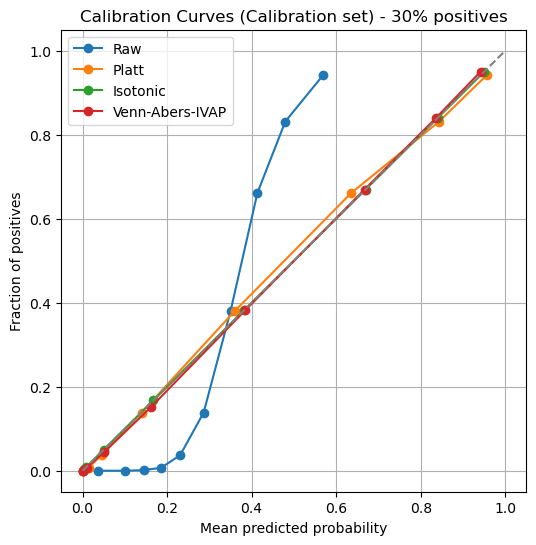

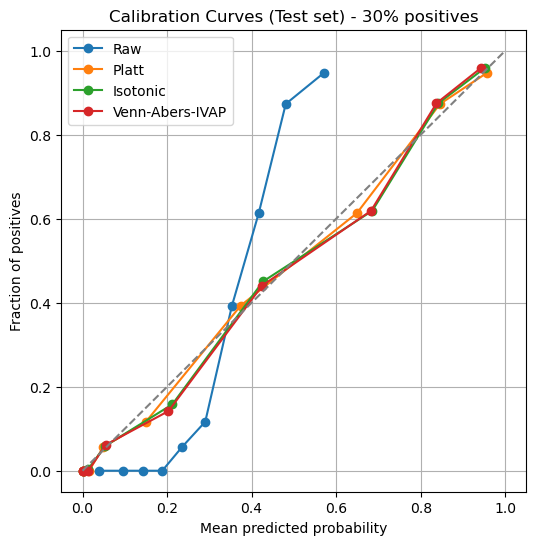

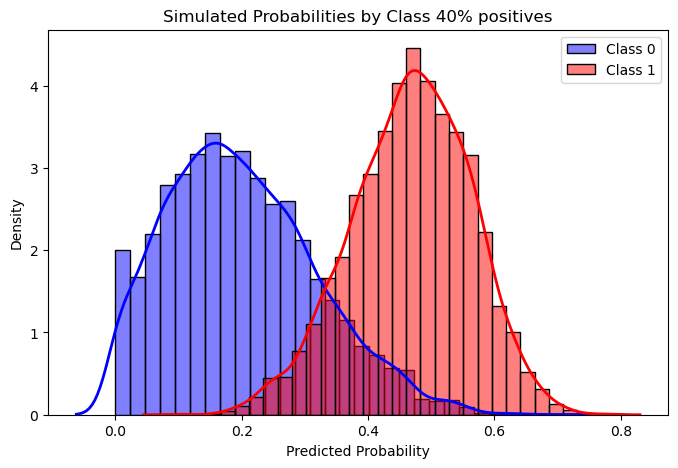


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4548,0.1496,0.9525,0.2160
Platt,0.2711,0.0839,0.9525,0.0081
Isotonic,0.2655,0.0825,0.9537,0.0000
Venn-Abers-IVAP,0.2669,0.0827,0.9535,0.0048



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4494,0.1473,0.9568,0.2210
Platt,0.2583,0.0787,0.9568,0.0142
Isotonic,0.2665,0.0783,0.9568,0.0102
Venn-Abers-IVAP,0.2560,0.0783,0.9569,0.0184


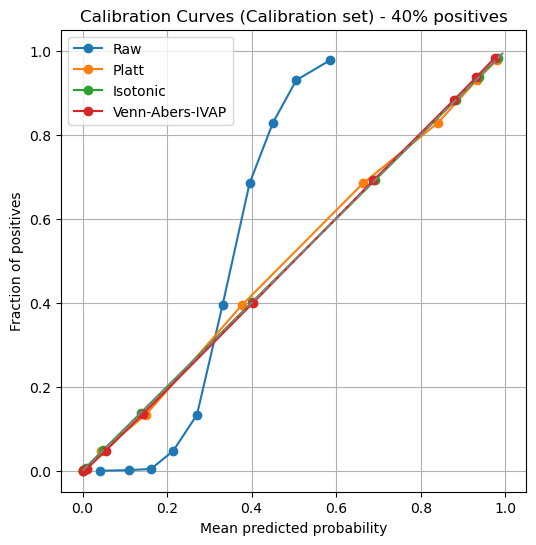

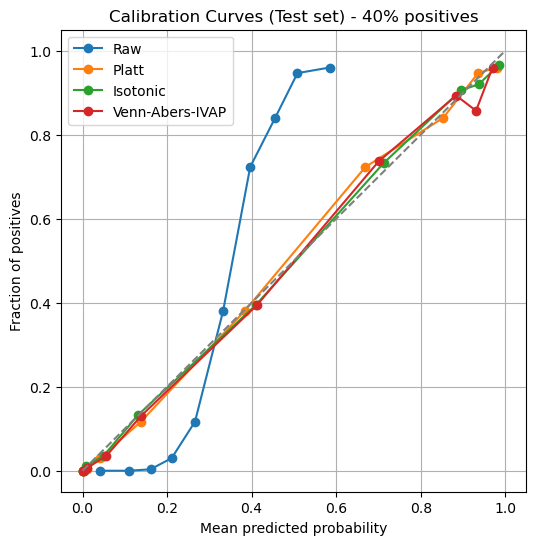

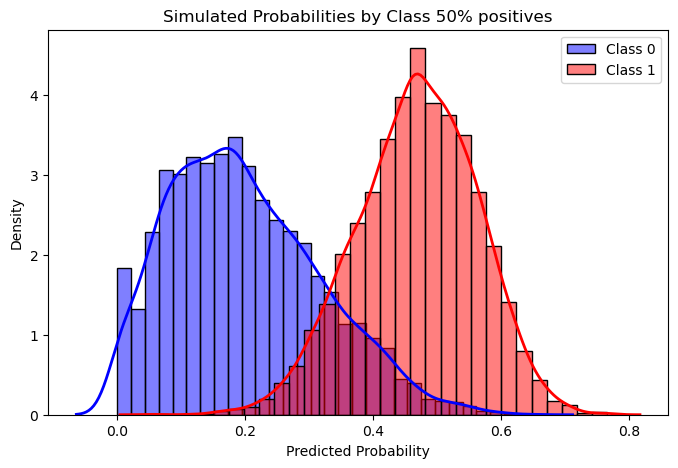


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5051,0.1714,0.9561,0.2611
Platt,0.2624,0.0797,0.9561,0.0101
Isotonic,0.2571,0.0785,0.9571,0.0000
Venn-Abers-IVAP,0.2584,0.0786,0.9570,0.0044



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5113,0.1745,0.9512,0.2562
Platt,0.2767,0.0855,0.9512,0.0165
Isotonic,0.2782,0.0859,0.9507,0.0192
Venn-Abers-IVAP,0.2776,0.0858,0.9508,0.0198


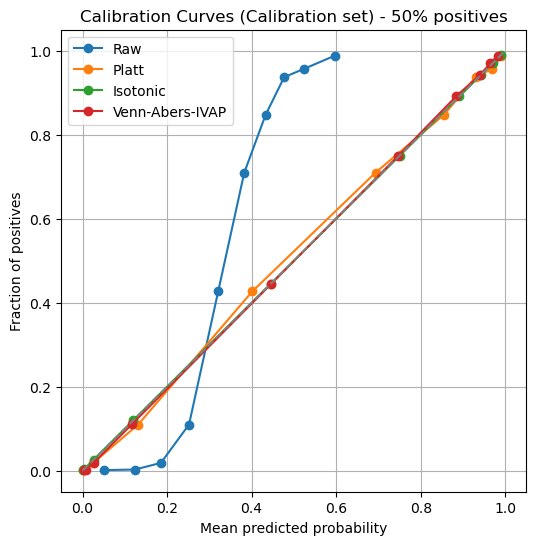

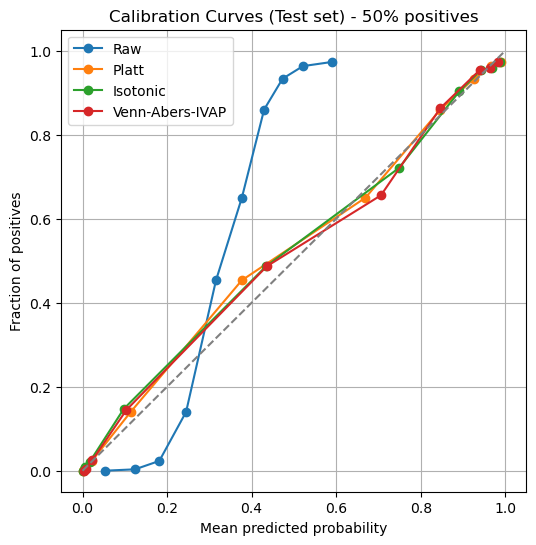

In [166]:
# Size of dataset: 10,000 samples
run_simulation({0: 9500, 1: 500}, title="5% positives")

run_simulation({0: 9000, 1: 1000}, title="10% positives")

run_simulation({0: 8000, 1: 2000}, title="20% positives")

run_simulation({0: 7000, 1: 3000}, title="30% positives")

run_simulation({0: 6000, 1: 4000}, title="40% positives")

run_simulation({0: 5000, 1: 5000}, title="50% positives")


# # Balanced (equal classes)
# run_simulation({0: 10000, 1: 10000}, title="Balanced classes")

# # Reversed imbalance (1 >> 0)
# run_simulation({0: 7108, 1: 25473}, title="Reversed imbalance")


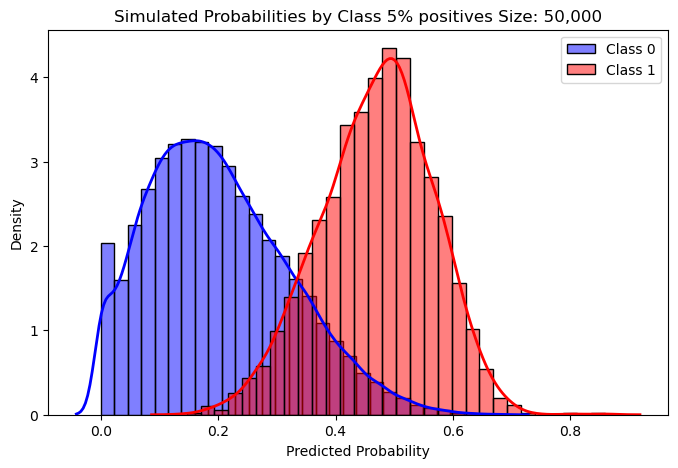


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2637,0.0664,0.9530,0.1645
Platt,0.1046,0.0309,0.9530,0.0014
Isotonic,0.1029,0.0305,0.9539,0.0000
Venn-Abers-IVAP,0.1032,0.0305,0.9538,0.0008



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2614,0.0659,0.9489,0.1623
Platt,0.1068,0.0312,0.9489,0.0029
Isotonic,0.1074,0.0313,0.9482,0.0051
Venn-Abers-IVAP,0.1074,0.0313,0.9484,0.0035


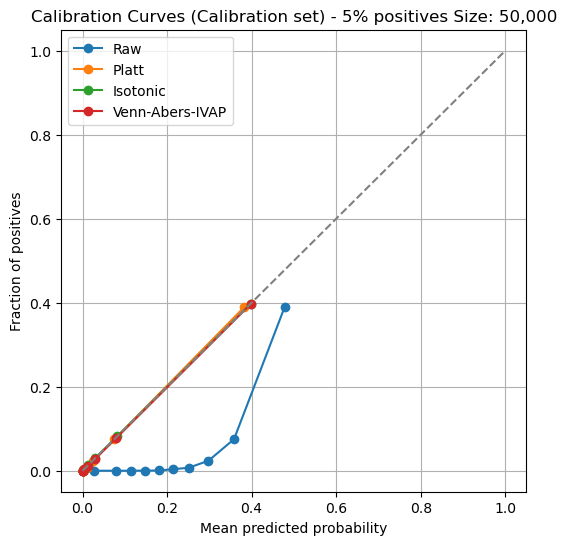

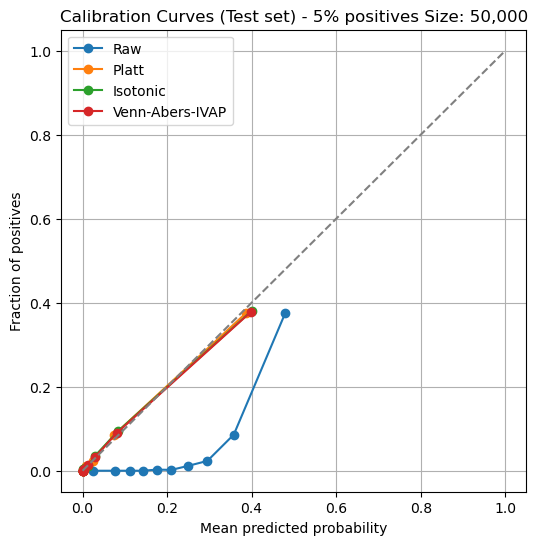

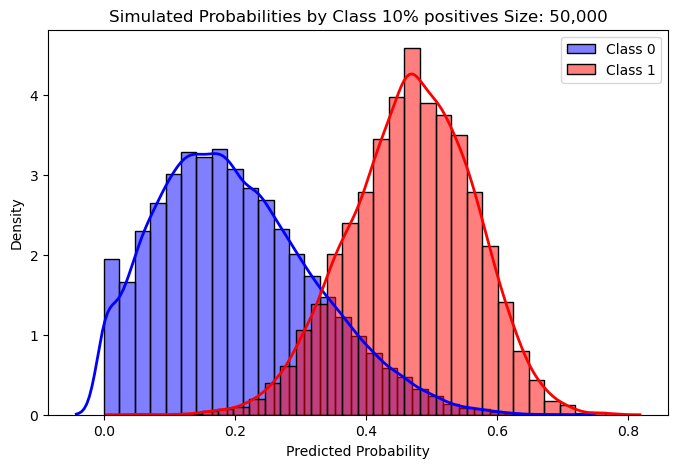


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2903,0.0780,0.9528,0.1553
Platt,0.1569,0.0485,0.9528,0.0050
Isotonic,0.1549,0.0481,0.9534,0.0000
Venn-Abers-IVAP,0.1552,0.0481,0.9533,0.0012



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2907,0.0782,0.9509,0.1567
Platt,0.1591,0.0486,0.9509,0.0020
Isotonic,0.1653,0.0486,0.9506,0.0052
Venn-Abers-IVAP,0.1591,0.0486,0.9506,0.0043


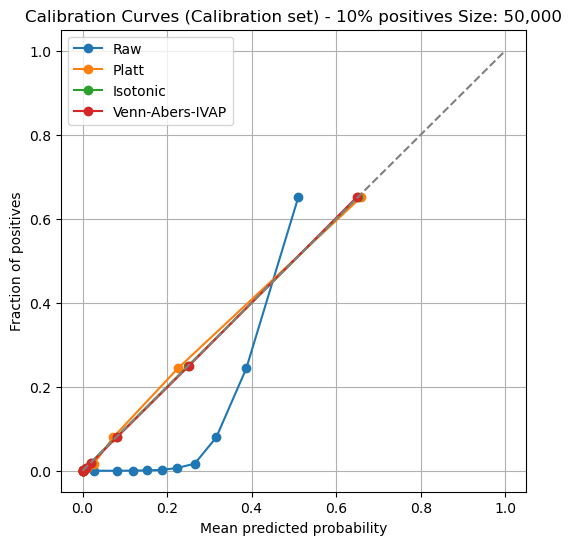

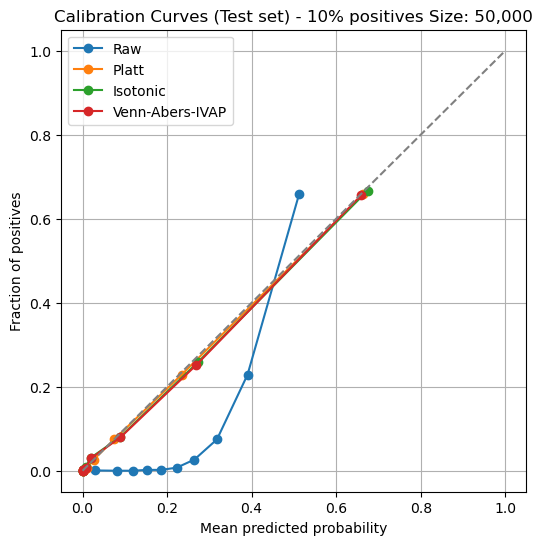

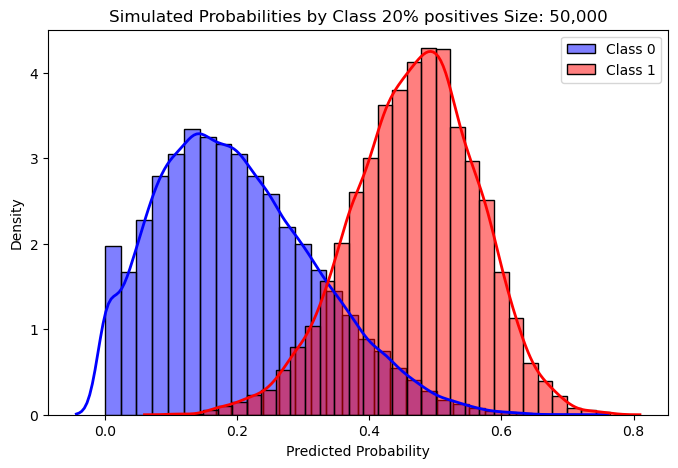


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3456,0.1021,0.9506,0.1564
Platt,0.2238,0.0697,0.9506,0.0065
Isotonic,0.2216,0.0692,0.9511,0.0000
Venn-Abers-IVAP,0.2219,0.0692,0.9511,0.0014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3441,0.1016,0.9524,0.1590
Platt,0.2202,0.0685,0.9524,0.0067
Isotonic,0.2196,0.0686,0.9523,0.0041
Venn-Abers-IVAP,0.2198,0.0686,0.9523,0.0047


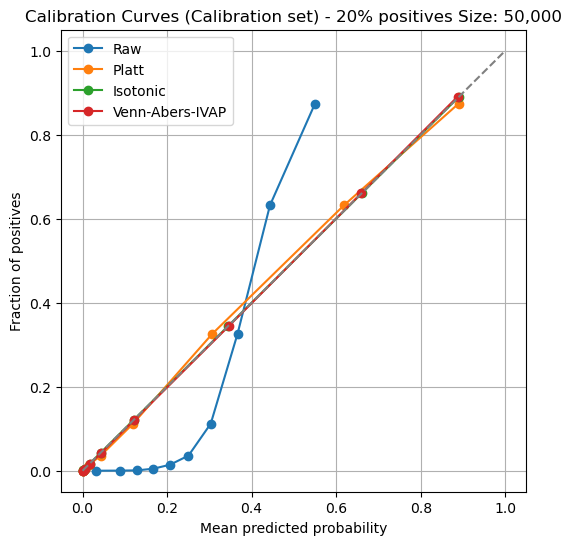

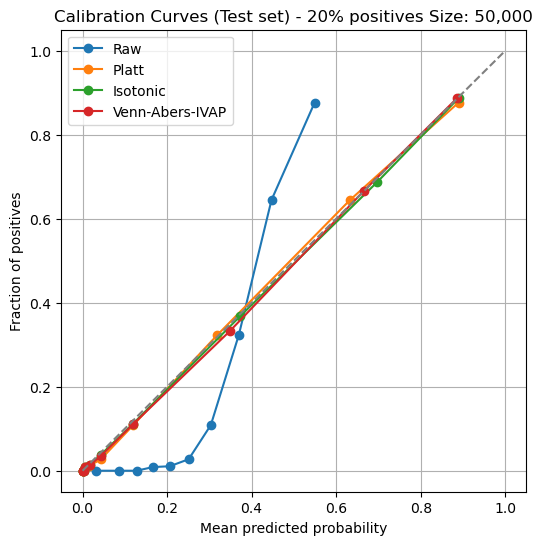

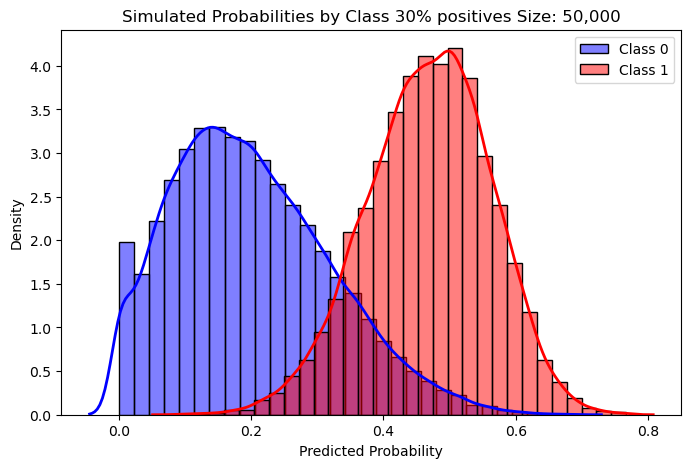


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3990,0.1255,0.9529,0.1814
Platt,0.2536,0.0788,0.9529,0.0097
Isotonic,0.2509,0.0782,0.9533,0.0000
Venn-Abers-IVAP,0.2512,0.0783,0.9532,0.0015



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4009,0.1261,0.9501,0.1791
Platt,0.2614,0.0812,0.9501,0.0092
Isotonic,0.2627,0.0812,0.9500,0.0042
Venn-Abers-IVAP,0.2605,0.0812,0.9501,0.0028


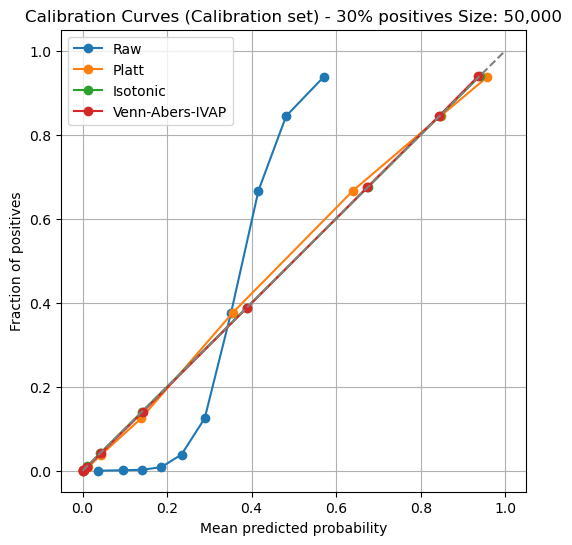

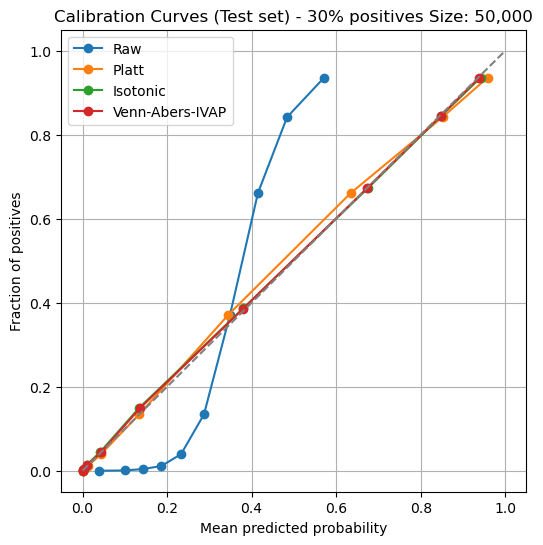

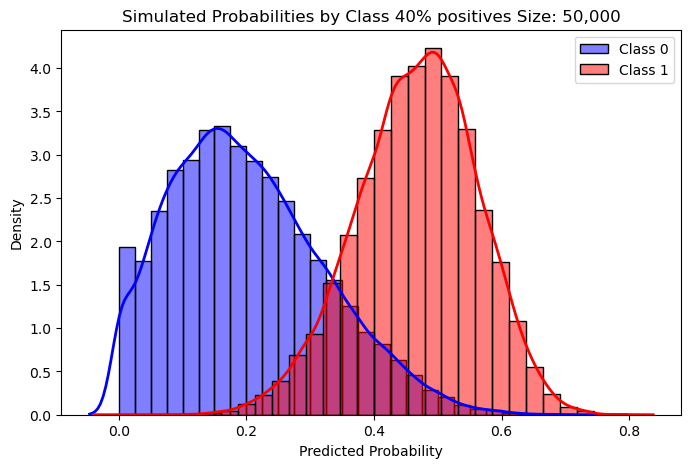


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4552,0.1499,0.9506,0.2129
Platt,0.2761,0.0853,0.9506,0.0055
Isotonic,0.2737,0.0848,0.9510,0.0000
Venn-Abers-IVAP,0.2740,0.0848,0.9510,0.0015



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.4588,0.1504,0.9496,0.2143
Platt,0.2801,0.0864,0.9496,0.0069
Isotonic,0.2801,0.0865,0.9495,0.0046
Venn-Abers-IVAP,0.2784,0.0865,0.9495,0.0051


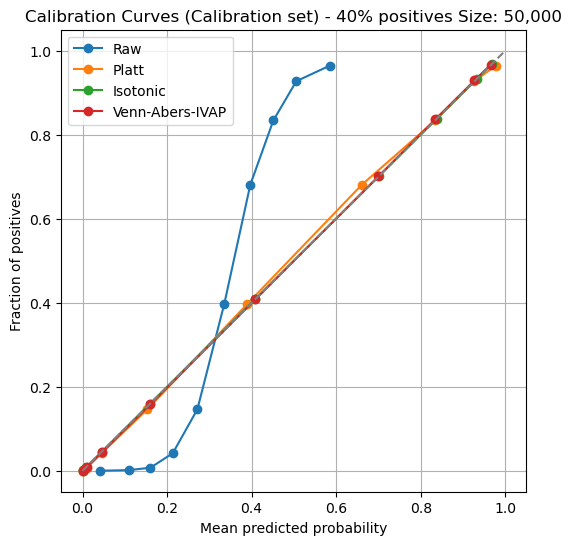

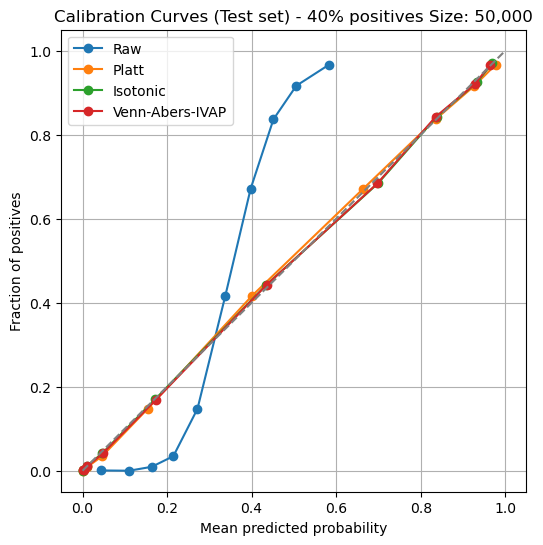

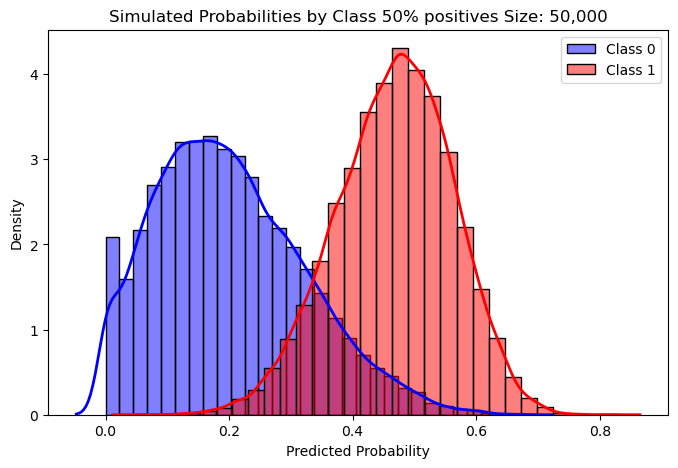


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5091,0.1733,0.9511,0.2557
Platt,0.2758,0.0839,0.9511,0.0082
Isotonic,0.2732,0.0834,0.9516,0.0000
Venn-Abers-IVAP,0.2736,0.0834,0.9515,0.0016



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5129,0.1750,0.9487,0.2545
Platt,0.2835,0.0861,0.9487,0.0094
Isotonic,0.2864,0.0859,0.9486,0.0057
Venn-Abers-IVAP,0.2820,0.0859,0.9486,0.0058


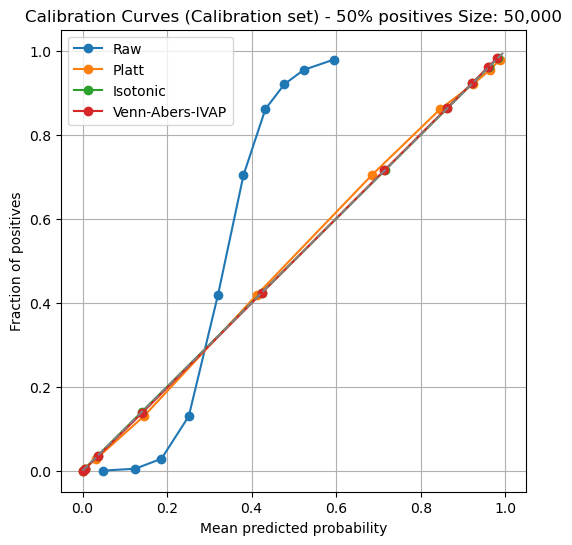

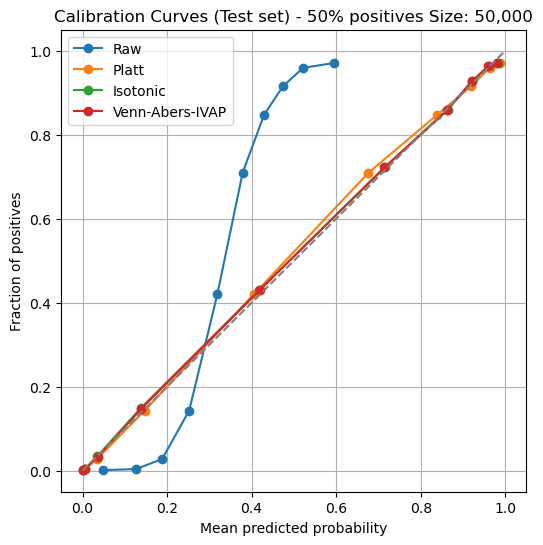

In [152]:
# Size of dataset: 50,000 samples
run_simulation({0: 47500, 1: 2500}, title="5% positives Size: 50,000")

run_simulation({0: 45000, 1: 5000}, title="10% positives Size: 50,000")

run_simulation({0: 40000, 1: 10000}, title="20% positives Size: 50,000")

run_simulation({0: 35000, 1: 15000}, title="30% positives Size: 50,000")

run_simulation({0: 30000, 1: 20000}, title="40% positives Size: 50,000")

run_simulation({0: 25000, 1: 25000}, title="50% positives Size: 50,000")